In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pickle
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Getting Dataset

In [3]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root='./data', download= True, train = False, transform = transforms.Compose([transforms.ToTensor()]))

## Making the data 3d and 224x224

In [4]:
import torch.nn.functional as F
import numpy as np
from scipy.ndimage import zoom

length = len(train_dataset.data)
train_data = []

for x in range(length):

    test, target = train_dataset.__getitem__(x)
    
    test = test.unsqueeze(0)
    
    desired_shape = (224, 224)
    resized_image = F.interpolate(test, size=desired_shape, mode='bilinear', align_corners=False)
    
    resized_image = resized_image.squeeze(0).squeeze(0)
    resized_image = resized_image.numpy()

    new_image = np.array([resized_image,resized_image,resized_image])
    new_image = torch.tensor(new_image)
    
    train_data.insert(x, [new_image, target])

test_file = '3d_224_test.pkl'

with open(os.getcwd() + '/data/pickle_out/' + test_file, 'rb') as file:
    test_data = pickle.load(file)

In [5]:
# FOR DUMPING OUT THE 3D TENSORS

# file_name = '3d_224_train.pkl' 

# with open(os.getcwd() + '/data/pickle_out/' + file_name, 'wb') as file:
#     pickle.dump(new_data, file)

In [6]:
from utils import FashionMnist_Dataset

train_dataset = FashionMnist_Dataset(train_data)
test_dataset = FashionMnist_Dataset(test_data)

BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
from utils import train_loop, test_loop, EarlyStopper
from pretrained_model import alexNet_pretrained

num_epochs = 60
lr = 0.001
patience = 5

early_stopper = EarlyStopper(patience=patience, min_delta=0)
model = alexNet_pretrained(train_last_layer_only= False)

model.to(device= device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

tr_acc, te_acc = [], []
tr_loss, te_loss = [], []

best_acc = 0

for epoch in range(num_epochs):
    train_loss, train_correct = train_loop(train_loader, model, loss_fn, optimizer, device)
    test_loss, test_correct = test_loop(test_loader, model, loss_fn, device)

    print('Train Acc epoch {} : {} '.format(epoch, train_correct))
    print('Test Acc epoch {} : {} '.format(epoch, test_correct))

    tr_acc.append(train_correct)
    te_acc.append(test_correct)

    tr_loss.append(train_loss)
    te_loss.append(test_loss)

    if early_stopper.early_stop(test_loss):
        print("Done! Early stopped at {}".format(epoch))
        break


Using cache found in C:\Users\ianch/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\ianch\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), 

Train Acc epoch 0 : 0.6774833333333333 
Test Acc epoch 0 : 0.7645 
Train Acc epoch 1 : 0.8057 
Test Acc epoch 1 : 0.817 
Train Acc epoch 2 : 0.8406333333333333 
Test Acc epoch 2 : 0.8323 
Train Acc epoch 3 : 0.8573666666666667 
Test Acc epoch 3 : 0.8608 
Train Acc epoch 4 : 0.8672 
Test Acc epoch 4 : 0.8682 
Train Acc epoch 5 : 0.8790166666666667 
Test Acc epoch 5 : 0.8739 
Train Acc epoch 6 : 0.8851166666666667 
Test Acc epoch 6 : 0.8831 
Train Acc epoch 7 : 0.89055 
Test Acc epoch 7 : 0.8795 
Train Acc epoch 8 : 0.8946666666666667 
Test Acc epoch 8 : 0.8784 
Train Acc epoch 9 : 0.8967 
Test Acc epoch 9 : 0.8869 
Train Acc epoch 10 : 0.8981166666666667 
Test Acc epoch 10 : 0.8899 
Train Acc epoch 11 : 0.90135 
Test Acc epoch 11 : 0.9058 
Train Acc epoch 12 : 0.9049 
Test Acc epoch 12 : 0.8979 
Train Acc epoch 13 : 0.9079333333333334 
Test Acc epoch 13 : 0.9043 
Train Acc epoch 14 : 0.90875 
Test Acc epoch 14 : 0.9075 
Train Acc epoch 15 : 0.9110833333333334 
Test Acc epoch 15 : 0.9114

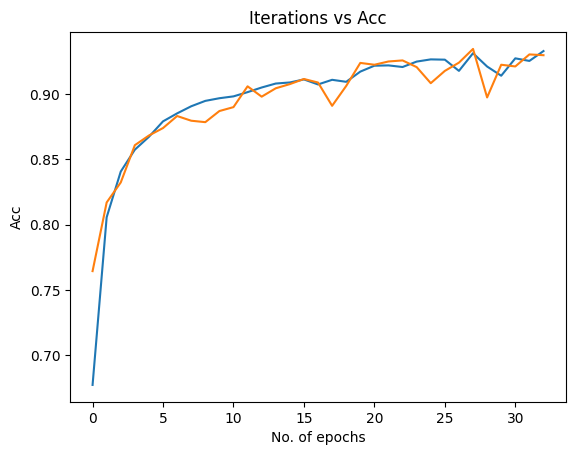

In [10]:
plt.plot(range(epoch+1), tr_acc)
plt.plot(range(epoch+1), te_acc)
plt.xlabel("No. of epochs")
plt.ylabel("Acc")
plt.title("Iterations vs Acc")
plt.show()

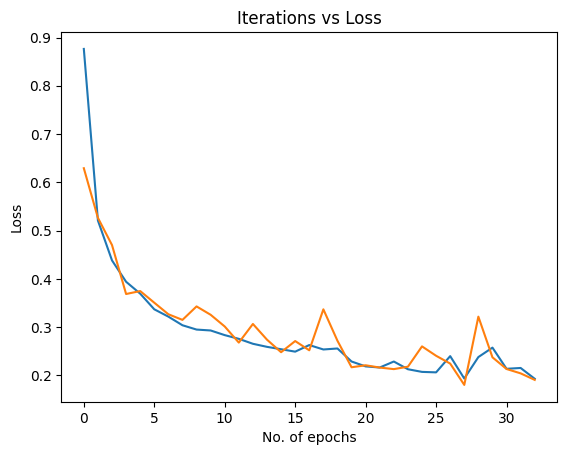

In [11]:
plt.plot(range(epoch+1), tr_loss)
plt.plot(range(epoch+1), te_loss)
plt.xlabel("No. of epochs")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

In [12]:
print("Best Acc : {} | Best Epoch : {}".format(max(te_acc), te_acc.index(max(te_acc))))

Best Acc : 0.9344 | Best Epoch : 27


## Pickle out results and accuracies

In [13]:
import pickle
import os

file_name = 'pretrained_alexnet_nofreeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'wb') as file:
    pickle.dump(tr_acc, file)
    pickle.dump(te_acc, file)
    pickle.dump(tr_loss, file)
    pickle.dump(te_loss, file)

## Pickle in results and accuracies

In [15]:
file_name = 'pretrained_alexnet_nofreeze.pkl' 

with open(os.getcwd() + '/results/' + file_name, 'rb') as file:
    tr_acc = pickle.load(file)
    te_acc = pickle.load(file)
    tr_loss = pickle.load(file)
    te_loss = pickle.load(file)


print(tr_acc)
print(te_acc)
print(tr_loss)
print(te_loss)

[0.6774833333333333, 0.8057, 0.8406333333333333, 0.8573666666666667, 0.8672, 0.8790166666666667, 0.8851166666666667, 0.89055, 0.8946666666666667, 0.8967, 0.8981166666666667, 0.90135, 0.9049, 0.9079333333333334, 0.90875, 0.9110833333333334, 0.9072333333333333, 0.9107833333333333, 0.90925, 0.91705, 0.9215666666666666, 0.9218, 0.9205666666666666, 0.9247166666666666, 0.9264, 0.9261833333333334, 0.9176166666666666, 0.9311, 0.9209333333333334, 0.9139166666666667, 0.9272, 0.9252166666666667, 0.9327666666666666]
[0.7645, 0.817, 0.8323, 0.8608, 0.8682, 0.8739, 0.8831, 0.8795, 0.8784, 0.8869, 0.8899, 0.9058, 0.8979, 0.9043, 0.9075, 0.9114, 0.9087, 0.8909, 0.9061, 0.9237, 0.9223, 0.9248, 0.9256, 0.9205, 0.9082, 0.9176, 0.9239, 0.9344, 0.8973, 0.9223, 0.921, 0.9302, 0.9296]
[0.8763663682983374, 0.5208207990950359, 0.43814163500947484, 0.39386446694575394, 0.36925868639178366, 0.3368146652733085, 0.32163202219299164, 0.30376741320276057, 0.2948364214475221, 0.29294834748259996, 0.28332278502584773,